### Validation schema

In [1]:
# linear algebra
import numpy as np

#working with data in table structers
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt


# working with files
import sys
import os
from pathlib import Path
import csv

# to off warnings
import warnings
warnings.filterwarnings('ignore')

# validation schema 
import time
from datetime import timedelta, datetime
from sklearn.model_selection import TimeSeriesSplit
from collections import defaultdict
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from scipy.stats import randint, uniform

# advanced modeling
import optuna
import shap
shap.initjs()
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

# models
import random
import sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from xgboost import XGBRegressor
import catboost as cb

### Read data

In [2]:
%%time

# set the data path
train_test_data_path = Path('C:\Repository\DS-Intership-data') / 'train_test_data'

# initiate dict for data
data = {}

# load data to dict
for file_path in train_test_data_path.iterdir():
    if file_path.is_file():
        data[file_path.stem] = pd.read_csv(file_path, index_col=0)
        print(file_path.stem)

submission_example
test_data
train_data
CPU times: total: 21.7 s
Wall time: 24.2 s


### Validation schema

In [3]:
"""
    The following indexes will be used:
        
        from train_data:
          date_block_num
          shop_id
          item_category_id
          item_id
          item_cnt_month
        
        from test_data:
            shop_id',
            'item_id',
            'ID'

    Concept:
        Apply expanding window validation (except last month - target of competition)
        Monthly predictions
"""

class Validation:
    def __init__(self,
                 train_data,
                 test_data,
                 submission_example,
                 metrics=['rmse'],
                 n_splits=5,
                 model=cb.CatBoostRegressor(iterations=35, verbose=10),
                 check_nans = True,
                 dropna = False,
                 check_infs = True, 
                 plot=True,
                 test_size=0.2
                ):
        self.train_data = train_data
        self.test_data = test_data
        self.submission_example = submission_example
        self.metrics = metrics
        self.n_splits = n_splits
        self.model = model
        self.plot = plot
        self.test_size = test_size
        self.tscv = TimeSeriesSplit(n_splits=self.n_splits)

        # Check data for valid columns
        assert set([
                    'date_block_num',
                    'shop_id',
                    'item_id',
                    'item_cnt_month'
                   ]).issubset(train_data.columns),\
                "Invalid data"
        
        assert set([
                    'shop_id',
                    'item_id'
                   ]).issubset(test_data.columns),\
                "Invalid data"
        
        assert set([
                    'shop_id',
                    'item_id',
                    'ID'
                    ]).issubset(submission_example.columns),\
                "Invalid data"
        
        # Check for valid variables
        if dropna:
            self.train_data = self.train_data.dropna()
            self.test_data = self.test_data.dropna()
            
        if check_nans:
            assert self.train_data.isna().sum().sum() == 0, 'Train data have NaNs'
        if check_infs:
            assert np.isfinite(self.train_data).sum().sum() != 0, 'Train data have Infs'
        if check_nans:
            assert self.test_data.isna().sum().sum() == 0, 'Test data have NaNs'
        if check_infs:
            assert np.isfinite(self.test_data).sum().sum() != 0, 'Test data have Infs'
        
        # Сheck for sorting by timeseries data
        amount_of_unsorted_rows = len(self.train_data) - (self.train_data.date_block_num.diff().fillna(0) >= 0).sum()
        if amount_of_unsorted_rows != 0:
            print(f"Data is not sorted by time ({amount_of_unsorted_rows} rows), it will be further sorted automatically")
            self.train_data = self.train_data.sort_values(by=['date_block_num'])
            
        # Split to X and y
        self.X = self.train_data.drop(columns='item_cnt_month')
        self.y = self.train_data[['item_id', 'shop_id', 'item_cnt_month']]
        
        # Validation process visualisation
        if self.plot and n_splits > 1:
            split_history = {
                'Step': ["Step"+str(i) for i in range(1, self.n_splits+1)],
                'Train Data': [], 
                'Validation Data': []
            }
            self.tscv = TimeSeriesSplit(n_splits=self.n_splits)
            for train, val in self.tscv.split(self.train_data[['item_id', 'shop_id', 'item_cnt_month']]):    
                split_history['Train Data'].append(train.max()-train.min())
                split_history['Validation Data'].append(val.max()-val.min())
            df = pd.DataFrame(split_history)
            print(df)
            sns.set(style="whitegrid")
            plt.figure(figsize=(6, 5))
            sns.barplot(x='Step', y='Train Data', data=df, color='skyblue', label='Train Data')
            sns.barplot(x='Step', y='Validation Data', data=df, color='salmon', label='Validation Data', bottom=df['Train Data'])
            plt.title('Distribution of data for training and validation')
            plt.xlabel('Validation step')
            plt.ylabel('Data quantity')
            plt.legend(loc='upper right')
            plt.tight_layout()
            plt.show()
    
    def calculate_metrics(self, y_pred, y_true):
        rmse = mse(y_true, y_pred, squared=True)
        return rmse
    
    # Predict sales for target month (November 2015)
    def predict_target(self, predictions_by_ID = True):
        """
            Return target predictions in accordance with submission example
        """
        X_train, y_train = self.train_data.drop(columns=['item_cnt_month']),\
                           self.train_data.item_cnt_month
        X_test = self.test_data
        X_test['date_block_num'] = 34
        model = self.model
        
        model.fit(X_train, y_train)
        if predictions_by_ID:
            result = X_test.join(pd.DataFrame(index=X_test.index, data=model.predict(X_test.values),\
                                           columns=['item_cnt_month']))\
                                                [['item_id', 'shop_id', 'item_cnt_month']].\
                                merge(self.submission_example, on=['shop_id', 'item_id'], how='right')\
                    .drop_duplicates(['item_id', 'shop_id'])[['ID', 'item_cnt_month']].sort_values(by='ID')
            result.item_cnt_month = result.item_cnt_month.clip(0, 20).fillna(0) 
            return result
        else:
            return model.predict(X_val) 
    
    def validate(self, predictions_by_ID = True, type="score", plot=False):
        if self.n_splits > 1:
            score = []
            eval_report = {}
        
            # Evaluation loop
            step = 0
            for train, val in self.tscv.split(self.y):

                # Initialize steps and timer
                step += 1
                ts = time.time()

                # Split data step

                y_train, y_val = self.y.iloc[train].item_cnt_month, self.y.iloc[val].item_cnt_month
                X_train, X_val = self.X.iloc[train], self.X.iloc[val]            

                # Train step
                rng = np.random.RandomState(42)
                model = self.model

                if isinstance(model, sklearn.ensemble._forest.RandomForestRegressor):
                    model = self.model
                    model.fit(X_train, y_train)
                    y_pred_val = model.predict(X_val)
                    y_pred_train = model.predict(X_train)
                    val_error = [self.calculate_metrics(y_pred_val, y_val)]
                    train_error = [self.calculate_metrics(y_pred_train, y_train)]

                else:
                    if isinstance(model, cb.core.CatBoostRegressor):
                        # Split
                        train_data = cb.Pool(X_train, label=y_train)
                        valid_data = cb.Pool(X_val, label=y_val)

                        # Train 
                        model.fit(train_data, eval_set=valid_data)

                        # Get error report
                        evals_result = model.get_evals_result()
                        train_error = evals_result['learn']['RMSE']
                        val_error = evals_result['validation']['RMSE']

                    if isinstance(model, XGBRegressor):
                        model = self.model
                        model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="rmse", eval_set=[(X_train, y_train), (X_val, y_val)], verbose=50)

                        # Get error report
                        evals_result = model.evals_result()
                        train_error = evals_result['validation_0']['rmse']
                        val_error = evals_result['validation_1']['rmse']

                    if isinstance(model, lgb.sklearn.LGBMRegressor):
                        assert self.params is not None, "params is None"
                        train_data = lgb.Dataset(X_train, label=y_train)
                        valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
                        model.fit(X_train, y_train, eval_set=[(X_val, y_val), (X_train, y_train)])

                        # Get error report
                        evals_result = model.evals_result_
                        train_error = evals_result['training']['l2']
                        val_error = evals_result['valid_0']['l2']

                    # Visualize
                    if plot:
                        plt.figure(figsize=(10, 6))
                        plt.plot(train_error, label='Train Error')
                        plt.plot(val_error, label='Validation Error')
                        plt.xlabel('Iterations')
                        plt.ylabel('RMSE Error')
                        plt.legend()
                        plt.title(f'{type(model)} Training and Validation Error')
                        plt.show()

                # Calculate time required for step
                time_info = time.time() - ts

                # Metrics calucaltion step
                eval_report["step"+str(step)] = {"Train/Validation error": [train_error[-1], val_error[-1]]}
                eval_report["step"+str(step)]["Train/Validation limits"] = f"TRAIN: from {train.min()} to  {train.max()}  (size: {train.max() - train.min()} ) " + f"VALIDATION: from {val.min()} to  {val.max()}  (size: {val.max() - val.min()} )"
                eval_report["step"+str(step)]["Time for step"]  = f"{time_info} s"
                eval_report["step"+str(step)]["__________________"] = "_________________________________________________________________________________"

                # calculate score
                score.append(val_error[-1])
        
        elif self.n_splits==1:
            # calculate score
            X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=self.test_size, shuffle=False)
            self.model.fit(X_train, y_train)
            score.append(self.calculate_metrics(y_val_pr.item_cnt_month, y_val.item_cnt_month))
        
        # Return result of validation        
        if type == "report":    
            return eval_report
        elif type=="score":
            return np.asarray(score).mean()

### Advanced modeling

In [4]:
class Pipeline:
    def __init__(self,
                 train_data,
                 test_data,
                 submission_example,
                 metrics=['rmse'],
                 model=cb.CatBoostRegressor(iterations=35, silent=True),
                 check_nans = True,
                 dropna = False,
                 check_infs = True,
                 feature_importance_layer=False,
                 hyperparametr_optimization_layer=False,
                 params = None,
                 optimizer="Grid",
                 selection_sample_size=None,
                 explainability_layer=False,
                 error_analysis_layer=False,
                 optimizer_iterations=20
                 ):
        self.train_data = train_data
        self.test_data = test_data
        self.submission_example = submission_example
        self.metrics = metrics
        self.model = model
        self.fitted_model = None
        self.predictions=None
        self.params = params
        self.optimal_hyperparametres = None
        self.important_features = None
        self.important_features_index = None
        self.selection_sample_size = selection_sample_size
        self.optimizer = optimizer
        self.optimizer_iterations = optimizer_iterations
        self.__feature_importance_layer__ = feature_importance_layer
        self.__hyperparametr_optimization_layer__=hyperparametr_optimization_layer
        self.__explainability_layer__=explainability_layer
        self.__error_analysis_layer__=error_analysis_layer
        self.selected_train_data=None
        self.selected_X=None
        self.selected_test_data=None
        
        # Check data for valid columns
        assert set([
                    'date_block_num',
                    'shop_id',
                    'item_id',
                    'item_cnt_month'
                   ]).issubset(train_data.columns),\
                "Invalid data"
        
        assert set([
                    'shop_id',
                    'item_id',
                   ]).issubset(test_data.columns),\
                "Invalid data"
        
        assert set([
                    'shop_id',
                    'item_id',
                    'ID'
                    ]).issubset(submission_example.columns),\
                "Invalid data"

        # Check for valid variables
        if dropna:
            self.train_data = self.train_data.dropna()
            self.test_data = self.test_data.dropna()
            
        if check_nans:
            assert self.train_data.isna().sum().sum() == 0, 'Train data have NaNs'
        if check_infs:
            assert np.isfinite(self.train_data).sum().sum() != 0, 'Train data have Infs'
        if check_nans:
            assert self.test_data.isna().sum().sum() == 0, 'Test data have NaNs'
        if check_infs:
            assert np.isfinite(self.test_data).sum().sum() != 0, 'Test data have Infs'
        
        # Сheck for sorting by timeseries data
        amount_of_unsorted_rows = len(self.train_data) - (self.train_data.date_block_num.diff().fillna(0) >= 0).sum()
        if amount_of_unsorted_rows != 0:
            print(f"Data is not sorted by time ({amount_of_unsorted_rows} rows), it will be further sorted automatically")
            self.train_data = self.train_data.sort_values(by=['date_block_num'])
        
         # Split to X and y
        self.X = self.train_data.drop(columns='item_cnt_month')
        self.X_for_train = None
        self.y = self.train_data[['item_id', 'shop_id', 'item_cnt_month']]
        
    def calculate_metrics(self, y_pred, y_true):
        rmse = mse(y_true, y_pred, squared=True)
        return rmse
    
    # Predict sales for target month (November 2015)
    def predict_target(self): # need to X_test contest item_id & shop_id columns
        """
            Return target predictions in accordance with submission example
        """ 
        if self.__feature_importance_layer__:
            X_train, y_train = self.selected_X, self.y.item_cnt_month
        else:
            X_train, y_train = self.X, self.y.item_cnt_month
        X_test = self.test_data
        X_test['date_block_num'] = 34
        
        if self.optimal_hyperparametres:
            model = cb.CatBoostRegressor(**optimal_hyperparametres, verbose=35)
        elif self.params:
            model = cb.CatBoostRegressor(**self.params, verbose=35)
        else:
            model = self.model
        model.fit(X_train, y_train)
        
        # save model fitting
        self.fitted_model = model.copy()
        self.predictions=model.predict(X_test.values)
        
        result = X_test.join(pd.DataFrame(index=X_test.index, data=self.predictions,\
                                       columns=['item_cnt_month']))\
                                            [['item_id', 'shop_id', 'item_cnt_month']].\
                            merge(self.submission_example, on=['shop_id', 'item_id'], how='right')\
                .drop_duplicates(['item_id', 'shop_id'])[['ID', 'item_cnt_month']].sort_values(by='ID')
        result.item_cnt_month = result.item_cnt_month.clip(0, 20).fillna(0) 
        return result

    def validate(self, n_splits=5):
        
        if self.__feature_importance_layer__:
            train_data = self.selected_train_data 
            test_data = self.selected_test_data
            submission_example = self.submission_example
        else:
            train_data = self.train_data
            test_data = self.test_data
            submission_example = self.submission_example
            
        validation = Validation(
                 train_data,
                 test_data,
                 submission_example,
                 n_splits=n_splits,
                 model = self.model,
                 check_nans=False,
                 plot=False
                )
            
        return validation.validate()
    
    
    def feature_importance_layer(self, selector="Boruta"):
        sample_size = self.selection_sample_size 
        if sample_size is None:
            sample_size = self.train_data.shape[0]
        if selector=="Boruta":
            from boruta import BorutaPy
            
            # Select sample of data
            X = self.train_data.dropna().drop(columns='item_cnt_month')[:sample_size]
            y = self.train_data.dropna()[:sample_size].item_cnt_month
            np.int = np.int_
            np.float = np.float_
            np.bool=np.bool_

            # Init selector
            feat_selector = BorutaPy(RandomForestRegressor(max_depth=7, n_estimators=50),
                                     n_estimators='auto', 
                                     verbose=2, 
                                     max_iter=20,
                                     random_state=42,
                                 )

            # Fit selector
            feat_selector.fit(X.values, y.values)

            # Extract usefull features
            self.important_features_index = feat_selector.support_
            self.important_features = self.X.columns[feat_selector.support_].tolist()
            
            # Save info about usefull/useless features
            feature_importance_report = {
                "important_columns": self.train_data.drop(columns=['item_cnt_month'])\
                                                                       .iloc[:, feat_selector.support_].columns,
                "unimportant_columns": self.train_data.drop(columns=['item_cnt_month'])\
                                                                       .iloc[:, ~feat_selector.support_].columns,
                "feature_importance_scores" : feat_selector.ranking_
            }
            
            # Delete features marked as useless by Boruta
            train_important_features = self.important_features.copy()
            train_important_features.extend([
                    'shop_id',
                    'item_cnt_month'
                   ])
          
            test_important_features = self.important_features.copy()
            test_important_features.extend([
                    'shop_id',
                    'item_id',
                   ])
     
            
            X_important_features = self.important_features.copy()
            X_important_features.extend([
                    'date_block_num',
                    'shop_id',
                    'item_id'
                   ])
            
            self.selected_train_data = self.train_data[train_important_features]
            self.selected_X = self.X[X_important_features]
            self.selected_test_data = self.test_data[test_important_features]

            return feature_importance_report
        
    def hyperparametr_optimization_layer(self, optimizer="Grid"):
        
        if self.__feature_importance_layer__:
            train_data = self.selected_train_data 
            test_data = self.selected_test_data
            submission_example = self.submission_example
        else:
            train_data = self.train_data
            test_data = self.test_data
            submission_example = self.submission_example
        
        print(f"Count of using features {train_data.shape[1]}")
            
        if optimizer=="Optuna":
            
            # Optimization fucntion
            def objective(trial):
                params = {
                    "iterations": trial.suggest_int("iterations", 10, 250),
                    "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
                    "depth": trial.suggest_int("depth", 1, 10),
                    'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 2, log=True),
                    "subsample": trial.suggest_float("subsample", 0.05, 1.0),
                    "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
                }

                model = Validation(
                                 train_data,
                                 test_data,
                                 submission_example,
                                 n_splits=5,
                                 model = cb.CatBoostRegressor(**params, silent=True),
                                 check_nans=False,
                                 plot=False
                                )
                rmse = model.validate()
                return rmse
            
            study = optuna.create_study(direction='minimize')
            study.optimize(objective, n_trials=self.optimizer_iterations)
            
            print('Best hyperparameters:', study.best_params)
            print('Best RMSE:', study.best_value)
            
            return study.best_params
        
        if optimizer=="Hyperopt":
            
            # Optimization fucntion
            def objective(params):
            
                params['depth'] = int(params['depth'])

                # Model creation
                model = Validation(
                                train_data,
                                test_data,
                                submission_example,
                                n_splits=5,
                                model = cb.CatBoostRegressor(**params, silent=True),
                                check_nans=False,
                                plot=False
                          )

                # Calculate validation error
                return {'loss': model.validate(plot=False), 'status': STATUS_OK}

            # Define space for hyperparameters tuning
            
            space = {
                "iterations": hp.randint("iterations", 10, 250),
                'depth': hp.quniform('depth', 2, 10, 1),
                'learning_rate': hp.loguniform('learning_rate', -3, 0),
                'l2_leaf_reg': hp.loguniform('l2_leaf_reg', 1e-3, 2),
                "subsample": hp.uniform("subsample", 0.05, 1.0),
                "colsample_bylevel": hp.uniform("colsample_bylevel", 0.05, 1.0),
                
            }

            # Trials for recording optimization process
            trials = Trials()

            # TPE optimizer
            best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=self.optimizer_iterations, trials=trials)

            # Print best parameters
            print("Best parameters:")
            print(best)

            # Get best params
            best_params = {**space_eval(space, best)}
            
            return best_params
            
        
    def explainability_layer(self, ind_pred_to_expl=5, pred_with_high_sales=True):
        
        if self.__feature_importance_layer__:
            train_data = self.selected_train_data 
            test_data = self.selected_test_data
        else:
            train_data = self.train_data
            test_data = self.test_data
            
        if self.optimal_hyperparametres:
            model = cb.CatBoostRegressor(**optimal_hyperparametres, silent=True)
        elif self.params:
            model = cb.CatBoostRegressor(**self.params, silent=True)
        else:
            model = self.model
            
        model.fit(train_data.drop(columns='item_cnt_month'), train_data.item_cnt_month)

        explainer = shap.Explainer(model)
        shap_values = explainer(test_data)

        # collect SHAP values by item_id/shop_id combinations
        shap_info = {}
        shap_values.data = np.nan_to_num(shap_values.data, nan=0)
        if self.__feature_importance_layer__:
            for i in range(len(shap_values)):
                shap_info[tuple([int(float_num) for float_num in shap_values[i].data[-2:]])] = shap_values[i]
        else:
            for i in range(len(shap_values)):
                shap_info[tuple([int(float_num) for float_num in shap_values[i].data[1:3]])] = shap_values[i]
                
        # select shops/items combinations
        submission_examples = []
        for i in range(data['submission_example'].shape[0]):
            submission_examples.append(tuple(data['submission_example'].iloc[i][1:3]) )

        # create dict with ID <-> shop_id, item_id connection
        ID_by_shop_item = {'ID': [int(i) for i in data['submission_example'].ID],
                'shop_id': [int(i) for i in data['submission_example'].shop_id],
                'item_id': [int(i) for i in data['submission_example'].item_id]}
        df = pd.DataFrame(ID_by_shop_item)
        ID_to_shop_item = dict(zip(df['ID'], zip(df['shop_id'], df['item_id'])))

        # select predictions with high sales
        preds = data['test_data'].join(pd.DataFrame(index= data['test_data'].index, data=model.predict(data['test_data']),\
                                                   columns=['item_cnt_month']))\
                                                        [['item_id', 'shop_id', 'item_cnt_month']].\
                                        merge(data['submission_example'], on=['shop_id', 'item_id'], how='right')\
                            .drop_duplicates(['item_id', 'shop_id'])[['ID', 'item_cnt_month']].sort_values(by='ID').fillna(0)
        predictions_with_high_sales = preds.sort_values(by=['item_cnt_month'], ascending=False)[:100]

        if pred_with_high_sales==True:
            # visualize SHAP values for random submission predictions with high sales
            counter = 0
            while counter < ind_pred_to_expl:
                random_ID_with_high_sales = ID_to_shop_item\
                                            [predictions_with_high_sales.ID.sample().values[0]]
                if random_ID_with_high_sales in shap_info.keys():
                    counter +=1
                    shap.plots.waterfall(shap_info[random_ID_with_high_sales])

        else:
            # visualize SHAP values for random submission predictions
            counter = 0
            while counter < ind_pred_to_expl:   
                random_ID = ID_to_shop_item[int(preds.iloc[random.randint(0, preds.shape[0]-1)].ID)]
                if random_ID in shap_info.keys():
                    counter +=1
                    shap.plots.waterfall(shap_info[random_ID_with_high_sales])
                    plt.show()

        # visualize SHAP values aggregated by first 100 predictions
        shap.plots.force(shap_values[:100])
        plt.show()
        
        
    def error_analysis_layer(self):
        error_analysis_report = []
        
        X = self.X
        y = self.y.item_cnt_month

        #spit traind data 
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, shuffle=False) 

        # learn model on train
        model = self.model
        model.fit(X_train, y_train)

        # predict y_test
        y_pred = self.model.predict(X_test)
        
        #calculate error
        errors_info = pd.DataFrame({"y_pred": y_pred,
                                    "y_test": y_test, 
                                    "error": np.abs(y_pred-y_test),
                                    }).join(X_test)
        
        # adding 2 features for error analysis (one for small dynamic and another for big)
        errors_info['y_pred'] = round(errors_info.y_pred)
        errors_info[['y_pred', 'y_test']] = errors_info[['y_pred', 'y_test']].replace(0, 1)
        errors_info["error_type_1"] =  np.abs(errors_info.y_pred/errors_info.y_test)
        errors_info["error_type_2"] =  np.abs(errors_info.y_test/errors_info.y_pred)

        # k is the boundary separation coefficient based on the ratio of the predicted to the origin
        k = 10
        high_error_predictions = errors_info.sort_values(by=['error'], ascending=False).head(100)
        small_dynamic_is_poorly_predicted = errors_info[errors_info.error_type_1 > k].sort_values(by=['error_type_1'], ascending=False)
        big_target_is_poorly_predicted = errors_info[errors_info.error_type_2 > k].sort_values(by=['error_type_2'], ascending=False)
        percentage_of_big_small_poor_predictions = (errors_info[errors_info.error_type_1 > k].shape[0]\
                                                    + errors_info[errors_info.error_type_2 > k].shape[0])\
                                                    / X_test.shape[0] * 100
        items_most_often_errors_occur = {"small_dynamic": small_dynamic_is_poorly_predicted.groupby('item_id')['error']\
                                             .count()[small_dynamic_is_poorly_predicted.groupby('item_id')['error']\
                                             .count().sort_values(ascending=False) > 10].sort_values(ascending=False).index,
                                         "big_dynamic": big_target_is_poorly_predicted.groupby('item_id')['error']\
                                             .count()[big_target_is_poorly_predicted.groupby('item_id')['error']\
                                             .count().sort_values(ascending=False) > 10].sort_values(ascending=False).index
                                        }

        error_analysis_report = {
            "high_error_predictions": high_error_predictions,
            "poorly_small_dynamic": small_dynamic_is_poorly_predicted,
            "poorly_high_dynamic": big_target_is_poorly_predicted, 
            "percentage_of_big_small_poor_predictions" : f"{percentage_of_big_small_poor_predictions} %",
            "items_most_often_errors_occur": items_most_often_errors_occur
        }

        
        return error_analysis_report
    
    
    def evaluate(self):
        if self.__feature_importance_layer__:
            feature_importance_report = self.feature_importance_layer()
        if self.__hyperparametr_optimization_layer__:
            optimal_hyperparametres = self.hyperparametr_optimization_layer(optimizer=self.optimizer)
            predictions = self.predict_target()
        else:
            predictions = self.predict_target()
        
        if self.__explainability_layer__:
            self.explainability_layer()
            
        if self.__error_analysis_layer__:
            error_analysis_report = self.error_analysis_layer()
        
        if self.__feature_importance_layer__ and self.__error_analysis_layer__:
            return feature_importance_report, error_analysis_report, predictions
        elif self.__feature_importance_layer__:
            return feature_importance_report, predictions
        elif self.__error_analysis_layer__:
            return error_analysis_report, predictions
        else:
            return predictions

#### Feature selection layer test

In [19]:
%%time
CatBoostTestBoruta = Pipeline(train_data=data['train_data'],
                 test_data=data['test_data'],
                 submission_example=data['submission_example'],
                 metrics=['rmse'],
                 model = cb.CatBoostRegressor(iterations=35, verbose=10, random_state=42),
                 check_nans=False,
                 feature_importance_layer=True,
                 selection_sample_size=1000
                )

Data is not sorted by time (18781 rows), it will be further sorted automatically
CPU times: total: 4.16 s
Wall time: 4.69 s


In [20]:
%%time
feature_importance_report, boruta_test_submission = CatBoostTestBoruta.evaluate()

Iteration: 	1 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	2 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	3 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	4 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	5 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	6 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	7 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	8 / 20
Confirmed: 	3
Tentative: 	3
Rejected: 	26
Iteration: 	9 / 20
Confirmed: 	3
Tentative: 	3
Rejected: 	26
Iteration: 	10 / 20
Confirmed: 	3
Tentative: 	3
Rejected: 	26
Iteration: 	11 / 20
Confirmed: 	3
Tentative: 	3
Rejected: 	26
Iteration: 	12 / 20
Confirmed: 	3
Tentative: 	3
Rejected: 	26
Iteration: 	13 / 20
Confirmed: 	3
Tentative: 	3
Rejected: 	26
Iteration: 	14 / 20
Confirmed: 	3
Tentative: 	3
Rejected: 	26
Iteration: 	15 / 20
Confirmed: 	3
Tentative: 	3
Rejected: 	26
Iteration: 	16 / 20
Confirmed: 	3
Tentative: 	3
Rejected: 	26
Iteration: 	17 / 

In [21]:
feature_importance_report

{'important_columns': Index(['item_cnt_month_lag_1', 'item_cnt_month_lag_12',
        'avg_by_month_item_id_item_cnt_lag_1'],
       dtype='object'),
 'unimportant_columns': Index(['date_block_num', 'shop_id', 'item_id', 'item_category_id', 'type_code',
        'subtype_code', 'shop_city', 'shop_category', 'name2', 'name3',
        'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
        'avg_by_month_item_cnt_lag_1', 'avg_by_month_item_cnt_lag_2',
        'avg_by_month_item_cnt_lag_3', 'avg_by_month_item_cnt_lag_12',
        'avg_by_month_item_id_item_cnt_lag_2',
        'avg_by_month_item_id_item_cnt_lag_3',
        'avg_by_month_shop_item_cnt_lag_1', 'avg_by_month_shop_item_cnt_lag_2',
        'avg_by_month_shop_item_cnt_lag_3', 'avg_by_month_city_item_cnt_lag_1',
        'avg_by_month_cat_item_cnt_lag_1', 'delta_price_lag',
        'category_cluster_id', 'item_price_cluster_id', 'cluster_id',
        'item_shop_first_sale', 'item_first_sale'],
       dtype='object'),
 'feature_impor

#### Hyperparameters optimization layer test

In [24]:
%%time
CatBoostTestOptuna = Pipeline(train_data=data['train_data'],
                 test_data=data['test_data'],
                 submission_example=data['submission_example'],
                 metrics=['rmse'],
                 model = cb.CatBoostRegressor(random_state=42),
                 check_nans=False,
                 feature_importance_layer=False,
                 hyperparametr_optimization_layer=True,
                 optimizer="Optuna",
                 optimizer_iterations = 1,
                )

Data is not sorted by time (18781 rows), it will be further sorted automatically
CPU times: total: 6.22 s
Wall time: 15.8 s


In [25]:
# %%time
optuna_test_submission = CatBoostTestOptuna.evaluate()

[I 2023-10-12 11:15:15,777] A new study created in memory with name: no-name-066b8916-d41d-4cc1-a4da-46d237965de0


Count of using features 33


[I 2023-10-12 11:15:47,311] Trial 0 finished with value: 1.883401810509562 and parameters: {'iterations': 11, 'learning_rate': 0.078059403106127, 'depth': 3, 'l2_leaf_reg': 0.0014311572865332528, 'subsample': 0.5359940143905523, 'colsample_bylevel': 0.3043567207494445}. Best is trial 0 with value: 1.883401810509562.


Best hyperparameters: {'iterations': 11, 'learning_rate': 0.078059403106127, 'depth': 3, 'l2_leaf_reg': 0.0014311572865332528, 'subsample': 0.5359940143905523, 'colsample_bylevel': 0.3043567207494445}
Best RMSE: 1.883401810509562
0:	learn: 2.2003727	total: 279ms	remaining: 2.79s
10:	learn: 1.7954394	total: 2.87s	remaining: 0us


In [30]:
%%time

CatBoostTestHyperopt = Pipeline(train_data=data['train_data'],
                 test_data=data['test_data'],
                 submission_example=data['submission_example'],
                 metrics=['rmse'],
                 model = cb.CatBoostRegressor(verbose=35, random_state=42),
                 check_nans=False,
                 feature_importance_layer=False,
                 hyperparametr_optimization_layer=True,
                 optimizer="Hyperopt",
                 optimizer_iterations = 1,
                )

Data is not sorted by time (18781 rows), it will be further sorted automatically
CPU times: total: 5.73 s
Wall time: 10.1 s


In [31]:
%%time
hyperopt_test_submission = CatBoostTestHyperopt.evaluate()

Count of using features 33
100%|██████████████████████████████████████████████████| 1/1 [01:00<00:00, 60.69s/trial, best loss: 1.5345054242006935]
Best parameters:
{'colsample_bylevel': 0.39222445894499414, 'depth': 3.0, 'iterations': 58, 'l2_leaf_reg': 3.005197151287503, 'learning_rate': 0.2369156416730753, 'subsample': 0.4665257744091679}
0:	learn: 2.0775287	total: 267ms	remaining: 15.2s
35:	learn: 1.4489798	total: 10.3s	remaining: 6.26s
57:	learn: 1.4237718	total: 16.1s	remaining: 0us
CPU times: total: 4min 2s
Wall time: 1min 19s


#### Explainability layer Test

In [14]:
%%time
CatBoostSHAPTest = Pipeline(train_data=data['train_data'],
                 test_data=data['test_data'],
                 submission_example=data['submission_example'],
                 metrics=['rmse'],
                 model = cb.CatBoostRegressor(iterations=35, verbose=10, random_state=42),
                 check_nans=False,
                 feature_importance_layer=False,
                 hyperparametr_optimization_layer=False,
                 explainability_layer=True
                )

Data is not sorted by time (18781 rows), it will be further sorted automatically
CPU times: total: 4.52 s
Wall time: 5.25 s


Learning rate set to 0.5
0:	learn: 1.7660317	total: 1.28s	remaining: 43.6s
10:	learn: 1.4027484	total: 6.39s	remaining: 13.9s
20:	learn: 1.3564015	total: 10.9s	remaining: 7.29s
30:	learn: 1.3225926	total: 15.4s	remaining: 1.98s
34:	learn: 1.3104957	total: 17.3s	remaining: 0us


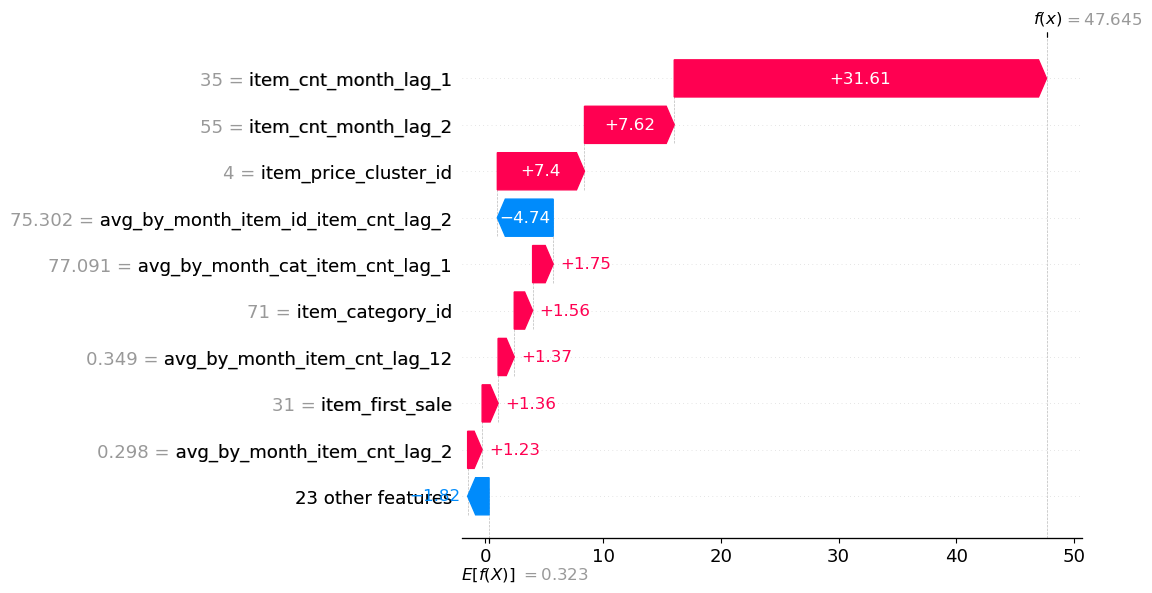

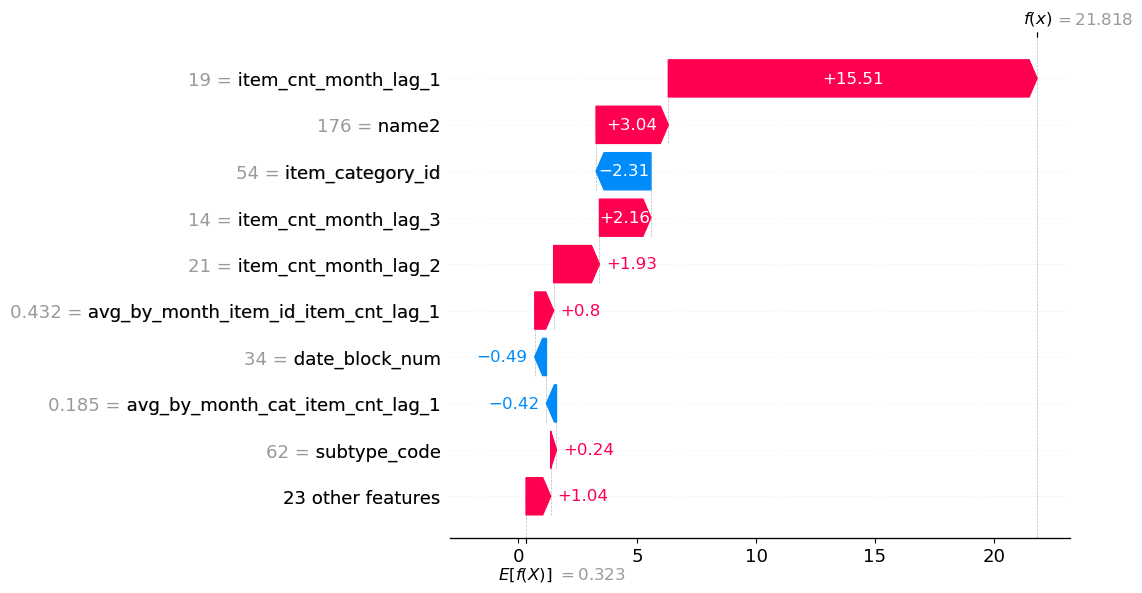

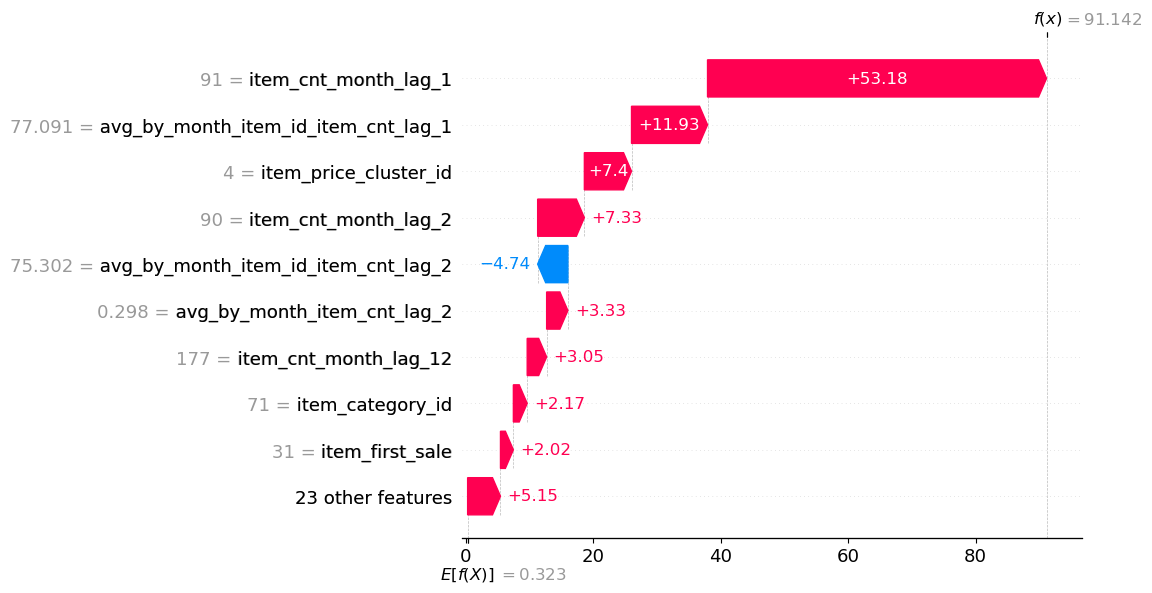

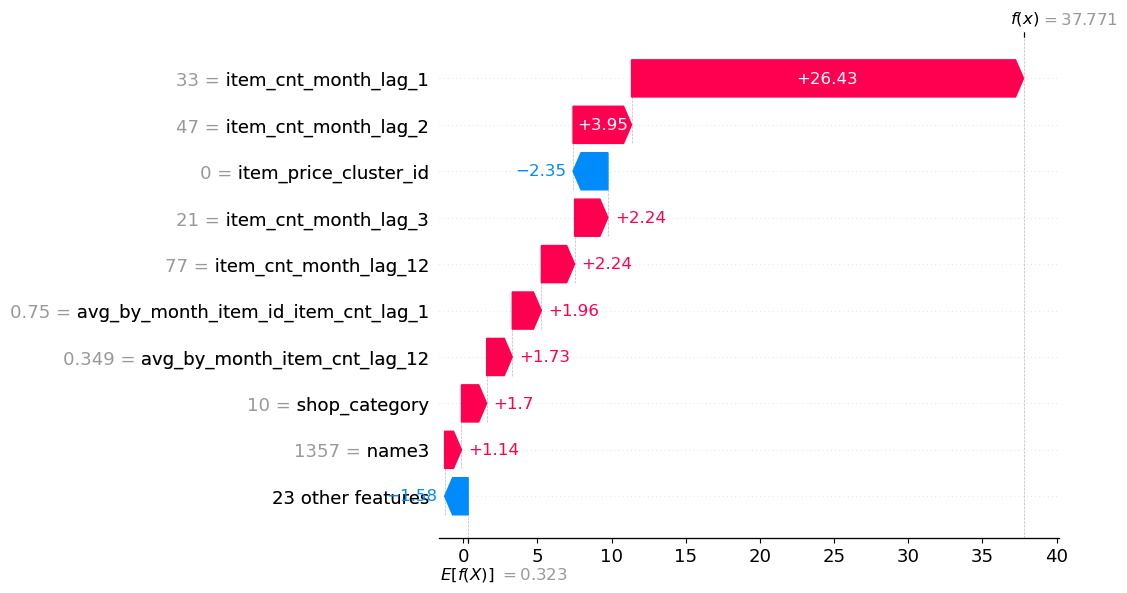

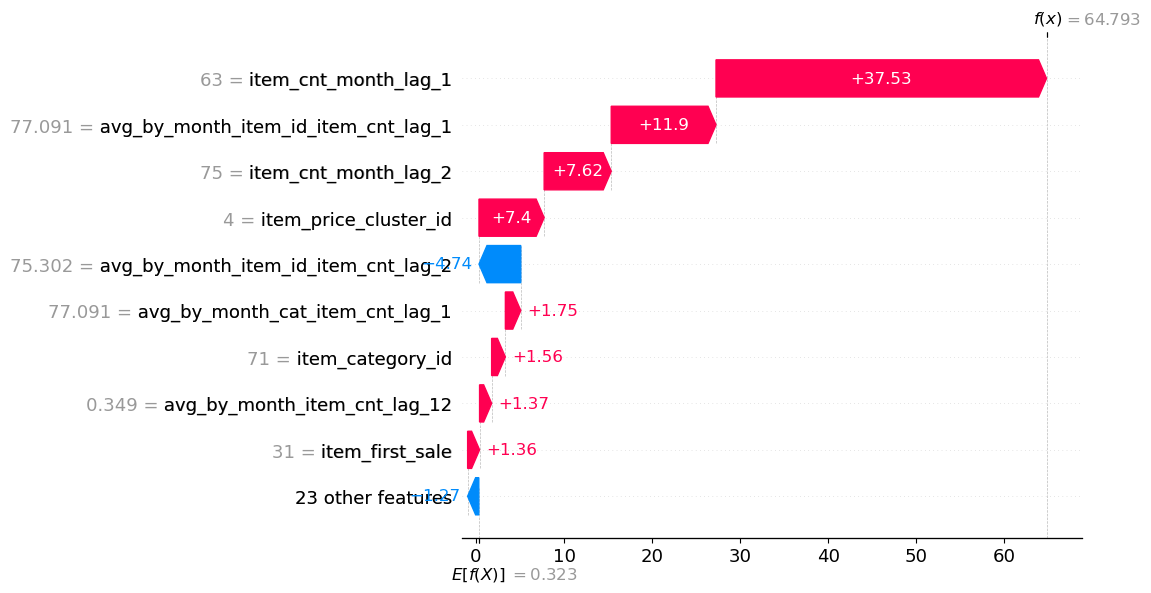

CPU times: total: 4min 37s
Wall time: 3min 20s


,ID,item_cnt_month
0,0,0.40
1,1,0.00
2,2,1.05
3,3,0.23
4,4,0.00
...,...,...
214195,214195,0.21
214196,214196,0.10
214197,214197,0.05
214198,214198,0.04


In [34]:
%%time
CatBoostSHAPTest.evaluate()

### Evaluate all pipeline layers 

In [5]:
%%time

CatBoostPipeline = Pipeline(train_data=data['train_data'],
                 test_data=data['test_data'],
                 submission_example=data['submission_example'],
                 metrics=['rmse'],
                 model = cb.CatBoostRegressor(random_state=42, iterations=35, silent=True),
                 check_nans=False,
                 feature_importance_layer=True,
                 selection_sample_size = 1000000,
                            
                 hyperparametr_optimization_layer=True,
                 optimizer="Optuna",
                 optimizer_iterations = 30,         
                            
                 explainability_layer=True,
                 error_analysis_layer=True,
                )

Data is not sorted by time (18781 rows), it will be further sorted automatically
CPU times: total: 3.78 s
Wall time: 4.15 s


In [8]:
%%time
predictions = CatBoostPipeline.evaluate()

CPU times: total: 2min 20s
Wall time: 22.4 s


In [9]:
predictions

,ID,item_cnt_month
0,0,0.40
1,1,0.00
2,2,1.05
3,3,0.23
4,4,0.00
...,...,...
214195,214195,0.21
214196,214196,0.10
214197,214197,0.05
214198,214198,0.04


In [ ]:
error_analysis['high_error_predictions']

In [ ]:
error_analysis['poorly_small_dynamic']

In [ ]:
error_analysis['poorly_high_dynamic']

In [ ]:
error_analysis['percentage_of_big_small_poor_predictions']

In [ ]:
error_analysis['items_most_often_errors_occur']

### Save final predictions

In [10]:
%%time
submission_data = {
    "advanced_predictions" : predictions
}

# add path to load 
path_to_load = Path("C:\Repository\DS-Intership-data") / "advanced_submissions"
os.makedirs(path_to_load, exist_ok=True)

# write data
for filename, df in submission_data.items():
    filepath = path_to_load / (filename + ".csv")
    predictions.to_csv(filepath, index=False)

CPU times: total: 219 ms
Wall time: 284 ms
